## Codes

### import

In [ ]:
import pandas as pd
import numpy as np
import random
import pickle

import collections
from collections import defaultdict, Counter

import scipy.sparse as sp
from sklearn.metrics import ndcg_score, dcg_score


from time import time
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

# from tensorflow.keras import backend as K
from tensorflow import keras
import argparse
tf.config.run_functions_eagerly(True)

### utils

In [ ]:
def parse_args():
    parser = argparse.ArgumentParser(description="Run GMF.")
    parser.add_argument('--path', nargs='?', default='data/',
                        help='Input data path.')
    parser.add_argument('--dataset', nargs='?', default='ml-1m',
                        help='Choose a dataset.')
    parser.add_argument('--nnModel', nargs='?', default='NextItNet_DistributedWeights', #[NextItNet_DistributedWeights, Bert4Rec]
                        help='Choose a recommender system model.')
    parser.add_argument('--mode', type=int, default=1,
                        help='Enter which uncertainty model is training')
    parser.add_argument('--seqlen', type=int, default=100,
                        help='Enter Sequence Length.')
    parser.add_argument('--T', type=int, default=10,
                        help='Enter T.')
    parser.add_argument('--tarlen', type=int, default=1,
                        help='Enter Target Length.')
    parser.add_argument('--setseed', type=int, default=2022,
                        help='Set a seed for random generator.')
    parser.add_argument('--max_epochs', type=int, default=10,
                        help='Number of epochs.')
    parser.add_argument('--embed_dims', type=int, default=32,
                        help='Embedding Dimension')
    parser.add_argument('--residual_channels', type=int, default=32,
                        help='CNN Residual Channels')
    parser.add_argument('--kernel_size', type=int, default=3,
                        help='CNN Kernel Size')
    parser.add_argument('--dilations', type=int, default=[1, 2, 4],
                        help='CNN Dilations')
    parser.add_argument('--batch_size', type=int, default=256,
                        help='Batch size.')
    parser.add_argument('--num_factors', type=int, default=8,
                        help='Embedding size.')
    parser.add_argument('--regs', nargs='?', default='[0,0]',
                        help="Regularization for user and item embeddings.")
    parser.add_argument('--num_neg', type=int, default=4,
                        help='Number of negative instances to pair with a positive instance.')
    parser.add_argument('--lr', type=float, default=0.001,
                        help='Learning rate.')
    parser.add_argument('--learner', nargs='?', default='adam',
                        help='Specify an optimizer: adagrad, adam, rmsprop, sgd')
    parser.add_argument('--verbose', type=int, default=1,
                        help='Show performance per X iterations')
    parser.add_argument('--out', type=int, default=1,
                        help='Whether to save the trained model.')
    return parser.parse_known_args()

args, __ = parse_args()


In [ ]:
# utils.py

def set_seed(seed, cuda=False):

    np.random.seed(seed)
    random.seed(seed)

set_seed(2023)

### Interactions


### Instance Spliter

In [ ]:
class Instances:
    def __init__(self, name=''):
        self.name=name
        self.sequences = []
        self.ratings = []
        self.users = []
        self.targets = []  # movie ids

    def shuffle(self):
        shuffle_indices = np.arange(len(self.sequences))
        np.random.shuffle(shuffle_indices)

        self.sequences = self.sequences[shuffle_indices]
        self.ratings = self.ratings[shuffle_indices]
        self.users = self.users[shuffle_indices]
        self.targets = self.targets[shuffle_indices]


    def pprint(self):
        print('Data Instances Shape:', self.name, end='\n')
        print('Sequences:', self.sequences.shape, 'Users:', self.users.shape, 'Targets:', self.targets.shape, 'Ratings:', self.ratings.shape)

class Interactions:
    def __init__(self, args):
        self.args = args
        self.sequence_length = args.seqlen
        self.target_length = args.tarlen
        self.data_root = args.path + args.dataset

        self.user_interactions = []
        self.user_ratings = []
        self.train = Instances(name='Train Instances')
        self.test = Instances(name='Test Instances')
        self.num_users = 0
        self.num_items = 0
        self.num_sequences = 0

    def process_dataset(self):
        print('Root', self.data_root)
        self._read_file('ml-100k')
        self.user_interactions = np.array(self.user_interactions, dtype=object)
        self.user_ratings = np.array(self.user_ratings, dtype=object)

        self.num_users = self.user_interactions.shape[0]
        self.num_items = int(np.max(np.concatenate(self.user_interactions[:])))

        print('num_users = ', self.num_users)
        print('num_items = ', self.num_items)

    def _read_file(self, file_path):
        with open(file_path, 'r') as fin:
            for line in fin:
                item_ratings = line.strip().split()[1:]
                item_ratings_np = np.array(item_ratings).astype(np.int64).reshape(-1, 2)
                
                ### users must have rated at least 15 items
                # if item_ratings_np.shape[0] >= 15:
                self.user_interactions.append(item_ratings_np[:, 0])
                self.user_ratings.append(item_ratings_np[:, 1])

    def create_instances(self):
        self._create_test_instances()
        self._create_train_instances()

    def _create_test_instances(self):

        ### Creating last item as prediction item
        ### Test targets are compaible with sigmoid output and sparse softmax out
        for user_id, interaction in enumerate(zip(self.user_interactions, self.user_ratings)):
            # interaction[0] --> user sequenes
            # interaction[1] --> user ratings
            sequence_interation = interaction[0]
            sequnece_rating = interaction[1]

            if len(sequence_interation) < 3:
                continue
            ### Users
            self.test.users.append(user_id)

            ### Targets
            self.test.targets.append(sequence_interation[-self.target_length:] - 1)

            ### Sequences
            sequence_interation = sequence_interation[:-self.target_length]  # Most important line
            sequnece_rating = sequnece_rating[:-self.target_length]  # Most important line

            if len(sequence_interation) < self.sequence_length:
                num_paddings = self.sequence_length - len(sequence_interation)
                sequence_interation = np.pad(sequence_interation, (num_paddings, 0), 'constant')
                sequnece_rating = np.pad(sequnece_rating, (num_paddings, 0), 'constant')
            else:
                sequence_interation = sequence_interation[-self.sequence_length:]
                sequnece_rating = sequnece_rating[-self.sequence_length:]

            self.test.sequences.append(sequence_interation)
            self.test.ratings.append(sequnece_rating)

        self.test.targets = np.array(self.test.targets).reshape(-1, self.target_length)
        ### users
        self.test.users = np.array(self.test.users).reshape(-1, 1)
        self.test.sequences = np.array(self.test.sequences)
        self.test.ratings = np.array(self.test.ratings)

        self.test.pprint()

    def _create_train_instances(self):
        max_sequence_length = self.sequence_length + self.target_length

        self.user_sequence_indexes = [list() for i in range(self.num_users)]

        sequence_index = 0
        for user_id, interaction in enumerate(zip(self.user_interactions, self.user_ratings)):
            # interaction[0] --> user sequenes
            # interaction[1] --> user ratings
            sequence_interation = interaction[0]
            sequnece_rating = interaction[1]

            if len(sequence_interation) < 3:
                continue
            sequence_interation = sequence_interation[:-self.target_length]  # Most important line
            sequnece_rating = sequnece_rating[:-self.target_length]  # Most important line

            if len(sequence_interation) < max_sequence_length:
                num_paddings = max_sequence_length - len(sequence_interation)
                sequence_interation = np.pad(sequence_interation, (num_paddings, 0), 'constant')
                sequnece_rating = np.pad(sequnece_rating, (num_paddings, 0), 'constant')

                self._add_sequence(
                    seq=sequence_interation[:self.sequence_length], 
                    usr=user_id, 
                    rating=sequnece_rating[:self.sequence_length], 
                    target=sequence_interation[-self.target_length:], 
                    sequence_index=sequence_index
                )
                sequence_index += 1

            else:
                for ind in range(len(sequence_interation), max_sequence_length - 1, -1):
                    temp_sequence = sequence_interation[ind - max_sequence_length: ind]
                    temp_rating = sequnece_rating[ind - max_sequence_length: ind]
                    self._add_sequence(
                        seq=temp_sequence[:self.sequence_length], 
                        usr=user_id, 
                        rating=temp_rating[:self.sequence_length], 
                        target=temp_sequence[-self.target_length:], 
                        sequence_index=sequence_index
                    )
                    sequence_index += 1

        self.train.sequences = np.array(self.train.sequences)
        self.train.ratings = np.array(self.train.ratings)
        self.train.users = np.array(self.train.users).reshape(-1, 1)
        self.train.targets = np.array(self.train.targets)
        self.train.pprint()

        for user_id in range(self.num_users):
            self.user_sequence_indexes[user_id] = np.array(self.user_sequence_indexes[user_id])
        self.user_sequence_indexes = np.array(self.user_sequence_indexes, dtype=object)

        self.num_sequences = sequence_index

    def _add_sequence(self, seq, usr, rating, target, sequence_index):
        self.train.sequences.append(seq)
        self.train.ratings.append(rating)
        self.train.users.append(usr)
        if target == 0:
            self.train.targets.append(target)
        else:
            self.train.targets.append(target - 1)

        self.user_sequence_indexes[usr].append(sequence_index)
        

In [ ]:
class InstanceSpliter:

    def __init__(self, data, k_fold = 5):
        self.data = data
        self.k_fold = k_fold

    def generate_folds(self):
        n_user_fold = self.data.num_users // self.k_fold
        user_ids = np.arange(self.data.num_users)
        np.random.shuffle(user_ids)

        ### Find folds for users
        self.user_fold_indexes = []
        for fold in range(self.k_fold):
            self.user_fold_indexes.append(user_ids[fold*n_user_fold : (fold+1)*n_user_fold])
        self.user_fold_indexes = np.array(self.user_fold_indexes)

    def get_sequence_indexes(self, fold_indexes):
        # print(fold_indexes)
        return np.concatenate(self.data.user_sequence_indexes[fold_indexes])

    def get_sequence(self, sequence_indexes, isTest=False):
        _instances = Instances()
        if isTest:
            _split_instances = self.data.test
        else:
            _split_instances = self.data.train

        print(type(sequence_indexes))
        _instances.users = _split_instances.users[sequence_indexes]
        _instances.sequences = _split_instances.sequences[sequence_indexes]
        _instances.ratings = _split_instances.ratings[sequence_indexes]
        _instances.targets = _split_instances.targets[sequence_indexes]

        return _instances

    def split_data(self, fold_id=0):
        if fold_id >= self.k_fold:
            raise Exception('Fold Id must be less than the k_fold')

        test_user_indexes = self.user_fold_indexes[fold_id]
        train_user_indexes = np.array(list(set(np.arange(self.data.num_users)) - set(self.user_fold_indexes[fold_id])))

        return self.create_split(train_user_indexes, test_user_indexes)
        
    def create_split(self, train_user_indexes, test_user_indexes):    
        train_sequence_indexes = self.get_sequence_indexes(train_user_indexes)
        validation_sequence_indexes = self.get_sequence_indexes(test_user_indexes)

        train_set = self.get_sequence(train_sequence_indexes)
        validation_set = self.get_sequence(validation_sequence_indexes)
        test_set = self.get_sequence(test_user_indexes, isTest=True)

        # if len(set(train_set.users.squeeze()).intersection(set(test_set.users.squeeze())))==0:
        # if len(set(train_user_indexes).intersection(set(test_user_indexes))) == 0:
        #     print('Well Done')
        # else:
        #     print('Error Splitting')
        print(train_set.users.shape, validation_set.users.shape, np.unique(train_set.users.squeeze()).shape, validation_set.users.shape)

        train_set.shuffle()
        validation_set.shuffle()
    
        return train_set, validation_set, test_set


def init(args, k_fold=5):
    set_seed(args.setseed)

    # load dataset
    instances = Interactions(args)
    instances.process_dataset()
    instances.create_instances()

    # get_target_samples(instances, num_negative_samples=1)

    instance_spliter = InstanceSpliter(data=instances, k_fold=k_fold)
    instance_spliter.generate_folds()

    return instances, instance_spliter

In [ ]:
args.path = ''
args.dataset = 'ml-100k' #'ml-1m','amazon-books' 
args.seqlen = 100
args.embed_dims=64
args.residual_channels=64

data, spliter = init(args)
train, validation, test = spliter.split_data(fold_id=0)

Root ml-100k
num_users =  943
num_items =  1681
Data Instances Shape: Test Instances
Sequences: (943, 100) Users: (943, 1) Targets: (943, 1) Ratings: (943, 100)
Data Instances Shape: Train Instances
Sequences: (38346, 100) Users: (38346, 1) Targets: (38346, 1) Ratings: (38346, 100)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(31922, 1) (6424, 1) (755,) (6424, 1)


### Uncertainty Calculations

In [ ]:
class nnRecSys:
    def __init__(self, args, data):
        self.T = args.T
        self.data = data
        self.saved_dir = 'results/'
        self.sequence_length = args.seqlen
        self.num_users = data.num_users
        self.num_items = data.num_items  # Consider padding 0 a prediction

    def compile_model(self, inputs, outputs):
        model = tf.keras.Model(
            inputs=inputs,
            outputs=outputs,
        )
        ### model compile
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3, beta_1=0.9, beta_2=0.999, clipvalue=1.0),
            # optimizer=tf.keras.optimizers.Adam(
            #     learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=200, decay_rate=0.80, staircase=True, name=None)
            #     # learning_rate=tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=1e-3, decay_steps=250, alpha=0.0, name=None)
            #     # learning_rate=tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-4, decay_steps=400, decay_rate=0.75, name=None)

            # ),
            # loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            loss=CustomSparseCategoricalCrossentropyLoss(self.T),
            metrics=[CustomSparseTopKCategoricalAccuracy],
        )

        return model

args.T = 1


#### NextItNet

Sampled Shape from distribution: (None, 1681)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 seq_input (InputLayer)      [(None, 100)]             0         
                                                                 
 seq_embedding (Embedding)   (None, 100, 64)           107648    
                                                                 
 conv1d (Conv1D)             (None, 98, 64)            12352     
                                                                 
 dropout (Dropout)           (None, 98, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 94, 64)            12352     
                                                                 
 dropout_1 (Dropout)         (None, 94, 64)            0         
                                                                 
 conv1d_2 (Conv

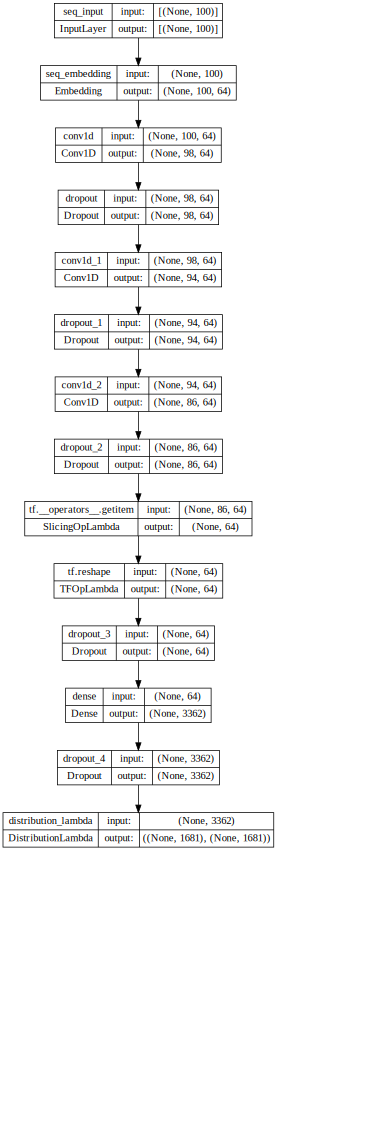

In [ ]:

def CustomLoss():
    def Custom_Loss(y_true, y_pred):
        # print(y_pred.shape)
        # print(y_true.shape)
        return tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred, from_logits=True)
    return Custom_Loss

lmbda = 0.125

def TopKSample(y_true, y_pred):
    y_pred = tf.nn.softmax(y_pred)
    m = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=20)
    m.update_state(y_true, y_pred)
    return m.result()

def CustomSparseTopKCategoricalAccuracy(y_true, y_pred, K=20):
    # print('Custom TopK', y_pred.shape)
    # y_pred = tf.reduce_mean(y_pred, axis=0)

    # varience = tf.reshape(y_pred[:,-1], (-1,1))
    # y_pred = y_pred[:,:-1]
    y_pred = tf.nn.softmax(y_pred)

    m = tf.keras.metrics.SparseTopKCategoricalAccuracy(k=K)
    m.update_state(y_true, y_pred)
    return m.result().numpy()



class NextItNet_Dropout(nnRecSys):
    def __init__(self, args, data):        
        super(NextItNet_Dropout, self).__init__(args, data)
        self.saved_dir = self.saved_dir + 'NextItNet_Dropout/' + args.dataset + '/'
        self.embed_dim = args.embed_dims                    # 256
        self.residual_channels = args.residual_channels     # 256
        self.dilations = args.dilations                     # [1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4]
        self.kernel_size = args.kernel_size            # 3

    def get_model(self, drop_prob=0.25, isDropoutTraining=True):
        # embed_dim = 64          # 256
        # embed_size = 64         # 256
        # dilations = [1, 2, 4]   # [1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4]
        # residual_channels = 32  # 256
        # kernel_size = 3         # 3

        seq_input = tf.keras.layers.Input(shape=(self.sequence_length,), name='seq_input')
        
        # (batch_size, sequence_length, embed_dim) --> (None, 100, 64)
        seq_embedding = tf.keras.layers.Embedding(
            input_dim = self.num_items + 1, 
            output_dim = self.embed_dim,
            name='seq_embedding',
            embeddings_initializer='uniform',       #embeding.weight.data.uniform_(-stdv, stdv) # important initializer, stdv = np.sqrt(1. / self.item_size)
            embeddings_regularizer=tf.keras.regularizers.L2(0)
        )(seq_input) #(batch_size, seq_len, embed_dim) = (None, 100, 64)
        # conv_layer = tf.keras.layers.Dropout(drop_prob)(seq_embedding, training=isDropoutTraining)
        conv_layer=seq_embedding

        # conv_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(conv_layer) #(batch_size, seq_len, embed_dim, 1) (None, 100, 64, 1)


        for dilation in self.dilations: #[1, 2, 4]

            conv_layer = tf.keras.layers.Conv1D(
                    self.residual_channels, 
                    kernel_size=self.kernel_size, 
                    dilation_rate=dilation, 
                    padding='valid', 
                    activation='tanh',
                )(conv_layer) # (batch_size, seq_len, embed_dim, residual_channels) = (None, 100, 98, 32), (None, 100, 94, 32), (None, 100, 86, 32)
            conv_layer = tf.keras.layers.Dropout(drop_prob)(conv_layer, training=isDropoutTraining)

        flatten_layer = tf.reshape(conv_layer[:, -1,], (-1, self.residual_channels)) # (batch_size, embed_dim) = (None, 32)
        flatten_layer = tf.keras.layers.Dropout(drop_prob)(flatten_layer, training=isDropoutTraining)
        

        fully_connected_layer = tf.keras.layers.Dense(self.num_items*2)(flatten_layer) # (batch_size, num_items) = (None, 3417)
        fully_connected_layer = tf.keras.layers.Dropout(drop_prob)(fully_connected_layer, training=isDropoutTraining)

        # output_layer = tf.keras.layers.concatenate([fully_connected_layer, variance_layer], name='output_layer')

        output_layer = tfpl.DistributionLambda(
            make_distribution_fn=lambda t: tfd.Normal(loc=t[..., :self.num_items], scale=tf.nn.softplus(t[..., self.num_items:])),
            # convert_to_tensor_fn=tfd.Distribution.sample
            # convert_to_tensor_fn=lambda s: s.sample(100)
        )(fully_connected_layer)
        # output_layer = output_layer[0]
        print('Sampled Shape from distribution:', output_layer.shape)
        # logits_variance = tf.keras.layers.concatenate([fully_connected_layer, variance_layer], name='logits_variance')

        # final_ratings = (1-lmbda) * fully_connected_layer
        #  + lmbda * output_layer
        # print(final_ratings.shape)
        # output_layer = tf.keras.layers.Dense(self.num_items)(output_layer)

        # output_layer = (1-lmbda) * fully_connected_layer[:, :-1] + lmbda * output_layer
        model = tf.keras.Model(
            inputs=seq_input,
            outputs=output_layer
            # outputs=fully_connected_layer[:, :self.num_items],
        )
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3, beta_1=0.9, beta_2=0.999, clipvalue=1.0),
            # optimizer=tf.keras.optimizers.Adam(
            #     learning_rate=tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-3, decay_steps=200, decay_rate=0.80, staircase=True, name=None)
            #     # learning_rate=tf.keras.optimizers.schedules.CosineDecay(initial_learning_rate=1e-3, decay_steps=250, alpha=0.0, name=None)
            #     # learning_rate=tf.keras.optimizers.schedules.InverseTimeDecay(initial_learning_rate=1e-4, decay_steps=400, decay_rate=0.75, name=None)

            # ),
            # loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            loss=CustomLoss(),            
            metrics=[TopKSample],
            # metrics=[CustomSparseTopKCategoricalAccuracy],
        )

        return model

def test_model(nnRecModel, train, val, test):
    max_epochs = 10
    verbose = 1
    batch_size = 512
    # for iteration in range(max_epochs):
    hist = nnRecModel.fit(train.sequences, train.targets,
        verbose=verbose, 
        batch_size=batch_size,
        epochs=max_epochs,
        # validation_data=(val.sequences, val.targets),
        # validation_batch_size=batch_size,
        callbacks=tf.keras.callbacks.TerminateOnNaN(),
    )
    y_pred = nnRecModel.predict(test.sequences, batch_size=batch_size)
    print('Test Accuracy with sample: ', CustomSparseTopKCategoricalAccuracy(test.targets, y_pred.sample()))
    print('Test Accuracy with mean: ', CustomSparseTopKCategoricalAccuracy(test.targets, y_pred.mean()))
    print('Test Accuracy: with stddev:', CustomSparseTopKCategoricalAccuracy(test.targets, y_pred.stddev()))
    return hist

# model = GRU(args, data, T=100).get_model(drop_prob=0.25)
model = NextItNet_Dropout(args, data).get_model(drop_prob=0.25)

# model = NextItNet_Dropout(data, T=100).get_model(drop_prob=0.25)
model.summary()
# hist = test_model(model, train, validation, test)
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
hist = test_model(model, train, validation, test)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


63/63 [==============================] - 16s 99ms/step - loss: 7.3319 - TopKSample: 0.0327
Epoch 2/10
63/63 [==============================] - 5s 81ms/step - loss: 7.0678 - TopKSample: 0.0459
Epoch 3/10
63/63 [==============================] - 6s 88ms/step - loss: 6.9968 - TopKSample: 0.0508
Epoch 4/10
63/63 [==============================] - 5s 86ms/step - loss: 6.8801 - TopKSample: 0.0689
Epoch 5/10
63/63 [==============================] - 5s 84ms/step - loss: 6.8111 - TopKSample: 0.0811
Epoch 6/10
63/63 [==============================] - 6s 90ms/step - loss: 6.7548 - TopKSample: 0.0873
Epoch 7/10
63/63 [==============================] - 5s 82ms/step - loss: 6.7010 - TopKSample: 0.0971
Epoch 8/10
63/63 [==============================] - 6s 92ms/step - loss: 6.6580 - TopKSample: 0.1046
Epoch 9/10
63/63 [==============================] - 5s 81ms/step - loss: 6.6189 - TopKSample: 0.1125
Epoch 10/10
1/1 [==============================] - 0s 147ms/step
Test Accuracy with sample:  0.079787

### NextItNet_Vanila

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 seq_input (InputLayer)      [(None, 100)]             0         
                                                                 
 seq_embedding (Embedding)   (None, 100, 64)           107584    
                                                                 
 conv1d_3 (Conv1D)           (None, 100, 64)           12352     
                                                                 
 dropout_5 (Dropout)         (None, 100, 64)           0         
                                                                 
 conv1d_4 (Conv1D)           (None, 100, 64)           12352     
                                                                 
 dropout_6 (Dropout)         (None, 100, 64)           0         
                                                                 
 conv1d_5 (Conv1D)           (None, 100, 64)           1235

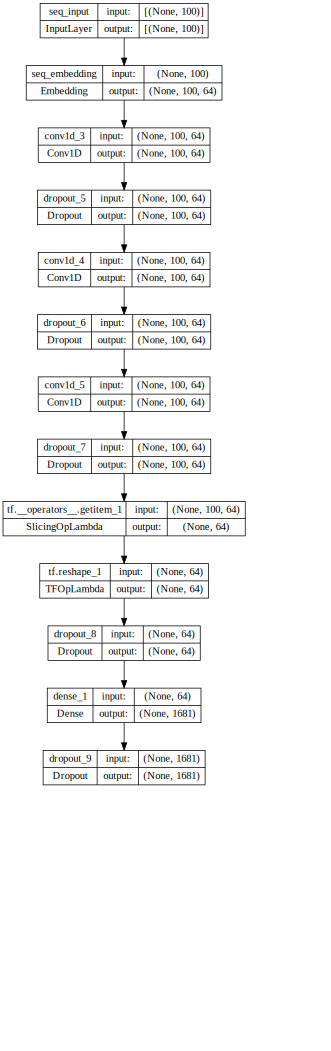

In [ ]:
class NextItNet_Dropout(nnRecSys):
    def __init__(self, args, data):        
        super(NextItNet_Dropout, self).__init__(args, data)
        self.saved_dir = self.saved_dir + 'NextItNet_Dropout/' + args.dataset + '/'
        self.embed_dim = args.embed_dims                    # 256
        self.residual_channels = args.residual_channels     # 256
        self.dilations = args.dilations                     # [1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4]
        self.kernel_size = args.kernel_size            # 3

    def get_model(self, drop_prob=0.25, isDropoutTraining=True):
        # embed_dim = 64          # 256
        # embed_size = 64         # 256
        # dilations = [1, 2, 4]   # [1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4]
        # residual_channels = 32  # 256
        # kernel_size = 3         # 3

        seq_input = tf.keras.layers.Input(shape=(self.sequence_length,), name='seq_input')

        # (batch_size, sequence_length, embed_dim) --> (None, 100, 64)
        seq_embedding = tf.keras.layers.Embedding(
            input_dim = self.num_items, 
            output_dim = self.embed_dim,
            name='seq_embedding',
            embeddings_initializer='uniform',       #embeding.weight.data.uniform_(-stdv, stdv) # important initializer, stdv = np.sqrt(1. / self.item_size)
            embeddings_regularizer=tf.keras.regularizers.L2(0)
        )(seq_input) #(batch_size, seq_len, embed_dim) = (None, 100, 64)
        # conv_layer = tf.keras.layers.Dropout(drop_prob)(seq_embedding, training=isDropoutTraining)
        conv_layer=seq_embedding

        # conv_layer = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1))(conv_layer) #(batch_size, seq_len, embed_dim, 1) (None, 100, 64, 1)


        for dilation in self.dilations: #[1, 2, 4]

            conv_layer = tf.keras.layers.Conv1D(
                    self.residual_channels, 
                    kernel_size=self.kernel_size,
                    dilation_rate=dilation, 
                    padding='same', 
                    activation='tanh',
                )(conv_layer) # (batch_size, seq_len, embed_dim, residual_channels) = (None, 100, 98, 32), (None, 100, 94, 32), (None, 100, 86, 32)
            conv_layer = tf.keras.layers.Dropout(drop_prob)(conv_layer, training=isDropoutTraining)

        flatten_layer = tf.reshape(conv_layer[:, -1,], (-1, self.residual_channels)) # (batch_size, embed_dim) = (None, 32)
        flatten_layer = tf.keras.layers.Dropout(drop_prob)(flatten_layer, training=isDropoutTraining)
        
        variance_layer = tf.keras.layers.Dense(self.num_items, activation='softplus',name='variance')(flatten_layer)

        fully_connected_layer = tf.keras.layers.Dense(self.num_items, activation=None)(flatten_layer) # (batch_size, num_items) = (None, 3417)
        fully_connected_layer = tf.keras.layers.Dropout(drop_prob)(fully_connected_layer, training=isDropoutTraining)

        model = tf.keras.Model(
            inputs=seq_input,
            outputs=fully_connected_layer,
        )

        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3, beta_1=0.9, beta_2=0.999, clipvalue=1.0),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[CustomSparseTopKCategoricalAccuracy],
        )

        return model

def test_model(nnRecModel, train, val, test):
    max_epochs = 10
    verbose = 1
    batch_size = 512
    # for iteration in range(max_epochs):
    hist = nnRecModel.fit(train.sequences, train.targets,
        verbose=verbose, 
        batch_size=batch_size,
        epochs=max_epochs,
        # validation_data=(val.sequences, val.targets),
        # validation_batch_size=batch_size,
        callbacks=tf.keras.callbacks.TerminateOnNaN(),
    )
    y_pred = nnRecModel.predict(test.sequences, batch_size=batch_size)
    print('Test Accuracy: ', CustomSparseTopKCategoricalAccuracy(test.targets, y_pred))
    return hist

# model = GRU(args, data, T=100).get_model(drop_prob=0.25)
model = NextItNet_Dropout(args, data).get_model(drop_prob=0.25)

# model = NextItNet_Dropout(data, T=100).get_model(drop_prob=0.25)
model.summary()
# hist = test_model(model, train, validation, test)
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
hist = test_model(model, train, validation, test)

Epoch 1/10
63/63 [==============================] - 9s 104ms/step - loss: 7.1730 - CustomSparseTopKCategoricalAccuracy: 0.0447
Epoch 2/10
63/63 [==============================] - 5s 79ms/step - loss: 6.9602 - CustomSparseTopKCategoricalAccuracy: 0.0546
Epoch 3/10
63/63 [==============================] - 8s 122ms/step - loss: 6.8915 - CustomSparseTopKCategoricalAccuracy: 0.0691
Epoch 4/10
63/63 [==============================] - 9s 145ms/step - loss: 6.7799 - CustomSparseTopKCategoricalAccuracy: 0.0848
Epoch 5/10
63/63 [==============================] - 5s 74ms/step - loss: 6.7160 - CustomSparseTopKCategoricalAccuracy: 0.0975
Epoch 6/10
63/63 [==============================] - 5s 83ms/step - loss: 6.6680 - CustomSparseTopKCategoricalAccuracy: 0.1085
Epoch 7/10
63/63 [==============================] - 5s 74ms/step - loss: 6.6176 - CustomSparseTopKCategoricalAccuracy: 0.1136
Epoch 8/10
63/63 [==============================] - 5s 75ms/step - loss: 6.5666 - CustomSparseTopKCategoricalAccura